<a href="https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/energyopt/ThermalEnergyAndNeqSim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyPSA: Python for Power System Analysis
https://pypsa.readthedocs.io/en/latest/index.html


Litterature:

https://nworbmot.org/courses/es-22/

https://nworbmot.org/courses/es-22/es-2-energy_balances.pdf

Knovel:
Infield, David Freris, Leon. (2020). Renewable Energy in Power Systems (2nd Edition). John Wiley & Sons. Retrieved from
https://app.knovel.com/hotlink/toc/id:kpREPSE003/renewable-energy-in-power/renewable-energy-in-power



In [3]:
!pip install highspy
!pip install pypsa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.8/170.8 kB 3.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.0/354.0 kB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 45.6 MB/s eta 0:00:00
  Created wheel for pypsa: filename=pypsa-0.25.1-py3-none-any.whl size=165980 sha256=44e206b88df646de424b63299d73aecf9603234b96a85eeb18537434ccf2d07b
  Stored in directory: /root/.cache/pip/wheels/21/c9/91/9e37644babcd9e22d1237e125fba7496a7cc197c7d96fb1a00
Successfully built pypsa


In [6]:
import pypsa
import numpy as np

network = pypsa.Network()

#add three buses
n_buses = 3

for i in range(n_buses):
    network.add("Bus", "My bus {}".format(i),  v_nom=20.)

        #add three lines in a ring
for i in range(n_buses):
    network.add("Line", "My line {}".format(i),
                bus0="My bus {}".format(i),
                bus1="My bus {}".format((i+1)%3),
                x=0.1,
                r=0.01)

#add a generator at bus 0
network.add("Generator", "My gen",
            bus="My bus 0",
            p_set=100,
            control="PQ")


#add a load at bus 1
network.add("Load", "My load",
            bus="My bus 1",
            p_set=100,
            q_set=100)

n_buses = 3

network.buses

attribute,v_nom,type,x,y,carrier,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,sub_network
Bus,,,,,,,,,,,
My bus 0,20.0,,0.0,0.0,AC,None,1.0,0.0,inf,PQ,
My bus 1,20.0,,0.0,0.0,AC,None,1.0,0.0,inf,PQ,
My bus 2,20.0,,0.0,0.0,AC,None,1.0,0.0,inf,PQ,


# Interaction with NeqSim

In [7]:
!pip install neqsim==2.5.35

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.3/28.3 MB 43.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 39.9 MB/s eta 0:00:00


# Introduction to TESPy and NeqSim interacations
We start by installing the TESTpy and neqsim python packages.

See: https://tespy.readthedocs.io/en/main/first_steps.html

Heat pump tutorial:
https://tespy.readthedocs.io/en/main/tutorials_examples.html#heat-pump-tutorial-label


In [ ]:
%%capture
!pip install tespy
!pip install neqsim==2.5.35
!pip install pygmo

# Simplest district heating system

In [ ]:
from tespy.networks import Network

# create a network object with water as fluid
fluid_list = ['water']
my_plant = Network(fluids=fluid_list)

# set the unitsystem for temperatures to °C and for pressure to bar
my_plant.set_attr(T_unit='C', p_unit='bar', h_unit='kJ / kg')

In [ ]:
from tespy.components import (
    Sink, Source, Pipe, Valve, HeatExchangerSimple)

# sources & sinks (central heating plant)
so = Source('heat source output')
si = Sink('heat source input')

# consumer
cons = HeatExchangerSimple('consumer')
cons.set_attr(Q=-10000, pr=0.98)  # Q in W
val = Valve('valve')
val.set_attr(pr=1)  # pr - pressure ratio (output/input pressure)

# pipes
pipe_feed = Pipe('pipe_feed')
pipe_back = Pipe('pipe_back')

pipe_feed.set_attr(ks=0.0005,  # pipe's roughness in meters
                   L=100,  # length in m
                   D=0.06,  # diameter in m
                   kA=10,  # area independent heat transfer coefficient kA in W/K
                   Tamb=10)  # ambient temperature of the pipe environment (ground temperature)
pipe_back.set_attr(ks=0.0005,
                   L=100,
                   D=0.06,
                   kA=10,
                   Tamb=10)

In [ ]:
from tespy.connections import Connection

# connections of the disctrict heating system
so_pif = Connection(so, 'out1', pipe_feed, 'in1')

pif_cons = Connection(pipe_feed, 'out1', cons, 'in1')
cons_val = Connection(cons, 'out1', val, 'in1')

val_pib = Connection(val, 'out1', pipe_back, 'in1')
pib_si = Connection(pipe_back, 'out1', si, 'in1')

# this line is crutial: you have to add all connections to your network
my_plant.add_conns(so_pif, pif_cons, cons_val, val_pib, pib_si)

so_pif.set_attr(T=90, p=15, fluid={'water': 1})
cons_val.set_attr(T=60)

In [ ]:
my_plant.solve(mode='design')
my_plant.print_results()

iter	| residual | massflow | pressure | enthalpy | fluid
--------+----------+----------+----------+----------+---------
1	| 1.44e+06 | 2.03e+00 | 2.60e+06 | 2.03e+05 | 0.00e+00
2	| 1.02e+04 | 1.64e-02 | 8.29e+03 | 8.28e+04 | 0.00e+00
3	| 6.47e+02 | 5.35e-05 | 7.84e-01 | 7.10e+03 | 0.00e+00


4	| 2.21e-01 | 6.71e-08 | 1.78e-03 | 2.47e+00 | 0.00e+00
5	| 8.19e-08 | 3.47e-14 | 9.88e-10 | 9.08e-07 | 0.00e+00
--------+----------+----------+----------+----------+---------
Total iterations: 5, Calculation time: 0.7 s, Iterations per second: 7.22
##### RESULTS (Pipe) #####
+-----------+-----------+----------+----------+----------+----------+----------+----------+----------+
|           |         Q |       pr |     zeta |        D |        L |       ks |       kA |     Tamb |
|-----------+-----------+----------+----------+----------+----------+----------+----------+----------|
| pipe_feed | -7.89e+02 | 1.00e+00 | 4.68e+06 | 6.00e-02 | 1.00e+02 | 5.00e-04 | 1.00e+01 | 1.00e+01 |
| pipe_back | -4.93e+02 | 1.00e+00 | 5.16e+06 | 6.00e-02 | 1.00e+02 | 5.00e-04 | 1.00e+01 | 1.00e+01 |
+-----------+-----------+----------+----------+----------+----------+----------+----------+----------+
##### RESULTS (HeatExchangerSimple) #####
+----------+-----------+----------+----------+-----+-----+----

# Clausis Rankine


In [ ]:
# -*- coding: utf-8 -*-

from tespy.networks import Network
from tespy.components import (Sink, Source, Turbine, Condenser,
                              Pump, HeatExchangerSimple, CycleCloser)
from tespy.connections import Connection, Bus, Ref
from tespy.tools.characteristics import CharLine
from tespy.tools import document_model
import numpy as np

# %% network

fluids = ['water']

nw = Network(fluids=fluids)
nw.set_attr(
    p_unit='bar', T_unit='C', h_unit='kJ / kg',
    p_range=[0.01, 150], h_range=[10, 5000])

# %% components

# main components
turb = Turbine('turbine')
con = Condenser('condenser')
pu = Pump('pump')
steam_generator = HeatExchangerSimple('steam generator')
closer = CycleCloser('cycle closer')

# cooling water
so_cw = Source('cooling water inlet')
si_cw = Sink('cooling water outlet')

# %% connections

# main cycle
fs_in = Connection(closer, 'out1', turb, 'in1')
ws = Connection(turb, 'out1', con, 'in1')
cond = Connection(con, 'out1', pu, 'in1')
fw = Connection(pu, 'out1', steam_generator, 'in1')
fs_out = Connection(steam_generator, 'out1', closer, 'in1')
nw.add_conns(fs_in, ws, cond, fw, fs_out)

# cooling water
cw_in = Connection(so_cw, 'out1', con, 'in2')
cw_out = Connection(con, 'out2', si_cw, 'in1')
nw.add_conns(cw_in, cw_out)

# %% busses

# characteristic function for generator efficiency
x = np.array([0, 0.2, 0.4, 0.6, 0.8, 1, 1.2])
y = np.array([0, 0.86, 0.9, 0.93, 0.95, 0.96, 0.95])

char = CharLine(x=x, y=y)

# motor of pump has a constant efficiency
power = Bus('total output power')
power.add_comps(
    {'comp': turb, 'char': char},
    {'comp': pu, 'char': char, 'base': 'bus'})
nw.add_busses(power)

# %% parametrization of components

turb.set_attr(eta_s=0.9, design=['eta_s'], offdesign=['eta_s_char', 'cone'])
con.set_attr(pr1=1, pr2=0.98, ttd_u=5, design=['pr2', 'ttd_u'],
             offdesign=['zeta2', 'kA_char'])
pu.set_attr(eta_s=0.8, design=['eta_s'], offdesign=['eta_s_char'])
steam_generator.set_attr(pr=0.95)

# %% parametrization of connections

# offdesign calculation: use parameter design for auto deactivation
# turbine inlet pressure is deriven by stodolas law, outlet pressure by
# characteristic of condenser
fs_in.set_attr(p=100, T=500, fluid={'water': 1}, design=['p'])

cw_in.set_attr(T=20, p=5, fluid={'water': 1})
cw_out.set_attr(T=30)

# total output power as input parameter
power.set_attr(P=-10e6)

# %% solving

# solve the network, print the results to prompt and save
nw.solve('design')
nw.print_results()
nw.save('design')
document_model(nw, filename='report_design.tex')

# reset power input
power.set_attr(P=-9e6)

# the design file holds the information on the design case
# initialisation from previously design process
nw.solve('offdesign', design_path='design')
nw.print_results()

document_model(nw, filename='report_offdesign.tex')

iter	| residual | massflow | pressure | enthalpy | fluid
--------+----------+----------+----------+----------+---------
1	| 1.50e+07 | 1.16e+03 | 2.85e+07 | 3.42e+06 | 0.00e+00
2	| 9.55e+06 | 8.34e+03 | 1.19e+07 | 1.43e+06 | 0.00e+00
3	| 1.14e+08 | 6.83e+03 | 5.64e+06 | 4.21e+05 | 0.00e+00
4	| 2.95e+07 | 1.11e+03 | 2.61e+06 | 2.95e+05 | 0.00e+00
5	| 1.92e+06 | 4.37e+01 | 1.18e+06 | 1.91e+05 | 0.00e+00
6	| 1.36e+06 | 3.73e+01 | 5.16e+05 | 1.00e+05 | 0.00e+00
7	| 7.63e+05 | 2.91e+01 | 2.13e+05 | 2.19e+04 | 0.00e+00
8	| 3.39e+05 | 2.31e+01 | 8.05e+04 | 5.70e+04 | 0.00e+00
9	| 1.95e+05 | 1.86e+01 | 2.56e+04 | 6.77e+04 | 0.00e+00
10	| 7.28e+04 | 1.52e+01 | 5.20e+03 | 6.25e+04 | 0.00e+00
11	| 1.47e+04 | 5.07e+00 | 1.22e+03 | 2.24e+04 | 0.00e+00
12	| 1.58e+03 | 1.85e-01 | 6.37e+01 | 1.03e+03 | 0.00e+00
13	| 3.67e+00 | 3.59e-04 | 2.23e-01 | 8.83e-01 | 0.00e+00
14	| 4.39e-05 | 1.69e-09 | 2.71e-06 | 2.54e-06 | 0.00e+00
--------+----------+----------+----------+----------+---------
Total iteratio

# Optimization example


Evolution: 0
Efficiency: 44.702 %

Evolution: 1
Efficiency: 44.8253 %

Evolution: 2
Efficiency: 44.826 %

Evolution: 3
Efficiency: 44.8584 %

Evolution: 4
Efficiency: 44.8584 %

Evolution: 5
Efficiency: 44.8586 %

Evolution: 6
Efficiency: 44.8586 %

Evolution: 7
Efficiency: 44.8586 %

Evolution: 8
Efficiency: 44.8594 %

Evolution: 9
Efficiency: 44.8594 %

Evolution: 10
Efficiency: 44.8594 %

Evolution: 11
Efficiency: 44.8596 %

Evolution: 12
Efficiency: 44.8596 %

Evolution: 13
Efficiency: 44.8596 %

Evolution: 14
Efficiency: 44.8596 %

Efficiency: 44.8596 %
Extraction 1: 25.797 bar
Extraction 2: 2.6853 bar


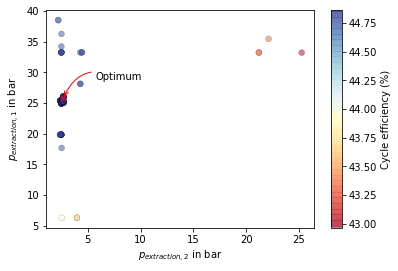

In [ ]:
#neqsim code here
from tespy.networks import Network
from tespy.components import (
    Turbine, Splitter, Merge, Condenser, Pump, Sink, Source,
    HeatExchangerSimple, Desuperheater, CycleCloser
)
from tespy.connections import Connection, Bus
from tespy.tools import document_model
from tespy.tools import logger
import logging

import pygmo as pg
import matplotlib.pyplot as plt
import numpy as np

logger.define_logging(screen_level=logging.ERROR)


class PowerPlant():
    def __init__(self):
        self.nw = Network(
            fluids=['BICUBIC::water'],
            p_unit='bar', T_unit='C', h_unit='kJ / kg',
            iterinfo=False)
        # components
        # main cycle
        eco = HeatExchangerSimple('economizer')
        eva = HeatExchangerSimple('evaporator')
        sup = HeatExchangerSimple('superheater')
        cc = CycleCloser('cycle closer')
        hpt = Turbine('high pressure turbine')
        sp1 = Splitter('splitter 1', num_out=2)
        mpt = Turbine('mid pressure turbine')
        sp2 = Splitter('splitter 2', num_out=2)
        lpt = Turbine('low pressure turbine')
        con = Condenser('condenser')
        pu1 = Pump('feed water pump')
        fwh1 = Condenser('feed water preheater 1')
        fwh2 = Condenser('feed water preheater 2')
        dsh = Desuperheater('desuperheater')
        me2 = Merge('merge2', num_in=2)
        pu2 = Pump('feed water pump 2')
        pu3 = Pump('feed water pump 3')
        me = Merge('merge', num_in=2)

        # cooling water
        cwi = Source('cooling water source')
        cwo = Sink('cooling water sink')

        # connections
        # main cycle
        cc_hpt = Connection(cc, 'out1', hpt, 'in1', label='feed steam')
        hpt_sp1 = Connection(hpt, 'out1', sp1, 'in1', label='extraction1')
        sp1_mpt = Connection(sp1, 'out1', mpt, 'in1', state='g')
        mpt_sp2 = Connection(mpt, 'out1', sp2, 'in1', label='extraction2')
        sp2_lpt = Connection(sp2, 'out1', lpt, 'in1')
        lpt_con = Connection(lpt, 'out1', con, 'in1')
        con_pu1 = Connection(con, 'out1', pu1, 'in1')
        pu1_fwh1 = Connection(pu1, 'out1', fwh1, 'in2')
        fwh1_me = Connection(fwh1, 'out2', me, 'in1', state='l')
        me_fwh2 = Connection(me, 'out1', fwh2, 'in2', state='l')
        fwh2_dsh = Connection(fwh2, 'out2', dsh, 'in2', state='l')
        dsh_me2 = Connection(dsh, 'out2', me2, 'in1')
        me2_eco = Connection(me2, 'out1', eco, 'in1', state='l')
        eco_eva = Connection(eco, 'out1', eva, 'in1')
        eva_sup = Connection(eva, 'out1', sup, 'in1')
        sup_cc = Connection(sup, 'out1', cc, 'in1')

        self.nw.add_conns(cc_hpt, hpt_sp1, sp1_mpt, mpt_sp2, sp2_lpt,
                          lpt_con, con_pu1, pu1_fwh1, fwh1_me, me_fwh2,
                          fwh2_dsh, dsh_me2, me2_eco, eco_eva, eva_sup, sup_cc)

        # cooling water
        cwi_con = Connection(cwi, 'out1', con, 'in2')
        con_cwo = Connection(con, 'out2', cwo, 'in1')

        self.nw.add_conns(cwi_con, con_cwo)

        # preheating
        sp1_dsh = Connection(sp1, 'out2', dsh, 'in1')
        dsh_fwh2 = Connection(dsh, 'out1', fwh2, 'in1')
        fwh2_pu2 = Connection(fwh2, 'out1', pu2, 'in1')
        pu2_me2 = Connection(pu2, 'out1', me2, 'in2')

        sp2_fwh1 = Connection(sp2, 'out2', fwh1, 'in1')
        fwh1_pu3 = Connection(fwh1, 'out1', pu3, 'in1')
        pu3_me = Connection(pu3, 'out1', me, 'in2')

        self.nw.add_conns(sp1_dsh, dsh_fwh2, fwh2_pu2, pu2_me2,
                          sp2_fwh1, fwh1_pu3, pu3_me)

        # busses
        # power bus
        self.power = Bus('power')
        self.power.add_comps(
            {'comp': hpt, 'char': -1}, {'comp': mpt, 'char': -1},
            {'comp': lpt, 'char': -1}, {'comp': pu1, 'char': -1},
            {'comp': pu2, 'char': -1}, {'comp': pu3, 'char': -1})

        # heating bus
        self.heat = Bus('heat')
        self.heat.add_comps(
            {'comp': eco, 'char': 1}, {'comp': eva, 'char': 1},
            {'comp': sup, 'char': 1})

        self.nw.add_busses(self.power, self.heat)

        # parametrization
        # components
        hpt.set_attr(eta_s=0.9)
        mpt.set_attr(eta_s=0.9)
        lpt.set_attr(eta_s=0.9)

        pu1.set_attr(eta_s=0.8)
        pu2.set_attr(eta_s=0.8)
        pu3.set_attr(eta_s=0.8)

        eco.set_attr(pr=0.99)
        eva.set_attr(pr=0.99)
        sup.set_attr(pr=0.99)

        con.set_attr(pr1=1, pr2=0.99, ttd_u=5)
        fwh1.set_attr(pr1=1, pr2=0.99, ttd_u=5)
        fwh2.set_attr(pr1=1, pr2=0.99, ttd_u=5)
        dsh.set_attr(pr1=0.99, pr2=0.99)

        # connections
        eco_eva.set_attr(x=0)
        eva_sup.set_attr(x=1)

        cc_hpt.set_attr(m=200, T=650, p=100, fluid={'water': 1})
        hpt_sp1.set_attr(p=20)
        mpt_sp2.set_attr(p=3)
        lpt_con.set_attr(p=0.05)

        cwi_con.set_attr(T=20, p=10, fluid={'water': 1})

        # test run
        self.nw.solve('design')
        document_model(self.nw)

    def calculate_efficiency(self, x):
        # set extraction pressure
        self.nw.get_conn('extraction1').set_attr(p=x[0])
        self.nw.get_conn('extraction2').set_attr(p=x[1])

        self.nw.solve('design')

        for cp in self.nw.comps['object']:
            if isinstance(cp, Condenser) or isinstance(cp, Desuperheater):
                if cp.Q.val > 0:
                    return np.nan
            elif isinstance(cp, Pump):
                if cp.P.val < 0:
                    return np.nan
            elif isinstance(cp, Turbine):
                if cp.P.val > 0:
                    return np.nan

        if self.nw.res[-1] > 1e-3 or self.nw.lin_dep:
            return np.nan
        else:
            return self.nw.busses['power'].P.val / self.nw.busses['heat'].P.val


class OptimizationProblem():

    def fitness(self, x):
        f1 = 1 / self.model.calculate_efficiency(x)
        ci1 = -x[0] + x[1]
        return [f1, ci1]

    def get_nobj(self):
        """Return number of objectives."""
        return 1

    # equality constraints
    def get_nec(self):
        return 0

    # inequality constraints
    def get_nic(self):
        return 1

    def get_bounds(self):
        """Return bounds of decision variables."""
        return ([1, 1], [40, 40])


optimize = OptimizationProblem()
optimize.model = PowerPlant()
prob = pg.problem(optimize)
num_gen = 15

pop = pg.population(prob, size=10)
algo = pg.algorithm(pg.ihs(gen=num_gen))

result = {'champion': [], 'efficiency': [], 'generation': [],
          'extraction 1': [], 'extraction 2': []}

for gen in range(num_gen):
    result["generation"].append(gen)
    result["champion"].append(100/pop.champion_f[0])

    decision_var = pop.get_x()
    for pressure in decision_var:
        result['extraction 1'].append(pressure[0])
        result['extraction 2'].append(pressure[1])

    fitness = pop.get_f()
    for efficiency in fitness:
        result['efficiency'].append(100/efficiency[0])

    print()
    print('Evolution: {}'.format(gen))
    print('Efficiency: {} %'.format(round(100 / pop.champion_f[0], 4)))
    pop = algo.evolve(pop)

print()
print('Efficiency: {} %'.format(round(100 / pop.champion_f[0], 4)))
print('Extraction 1: {} bar'.format(round(pop.champion_x[0], 4)))
print('Extraction 2: {} bar'.format(round(pop.champion_x[1], 4)))


# scatter plot
cm = plt.cm.get_cmap('RdYlBu')
sc = plt.scatter(result['extraction 2'], result['extraction 1'], linewidth=0.25,
                 c=result['efficiency'], cmap=cm, alpha=0.5, edgecolors='black')
plt.scatter(pop.champion_x[1], pop.champion_x[0], marker='x', linewidth=1,
            c='red')
plt.annotate('Optimum', xy=(pop.champion_x[1], pop.champion_x[0]),
             xytext=(pop.champion_x[1]+3, pop.champion_x[0]+3),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',
                             color='red')
            )
plt.ylabel('$p_{extraction, 1}$ in bar')
plt.xlabel('$p_{extraction, 2}$ in bar')
plt.colorbar(sc, label='Cycle efficiency (%)')
plt.savefig("scatterplot.svg")
plt.show()

# Optimize

https://esa.github.io/pygmo2/tutorials/coding_udp_constrained.html

In [ ]:
class Schaffer:
    # Define objectives
    def fitness(self, x):
        f1 = x[0]**2
        f2 = (x[0]-2)**2
        return [f1, f2]

    # Return number of objectives
    def get_nobj(self):
        return 2

    # Return bounds of decision variables
    def get_bounds(self):
        return ([0]*1, [2]*1)

    # Return function name
    def get_name(self):
        return "Schaffer function N.1"

In [ ]:
import pygmo as pg
# create UDP
prob = pg.problem(Schaffer())

In [ ]:
# create population
pop = pg.population(prob, size=20)
# select algorithm
algo = pg.algorithm(pg.nsga2(gen=40))
# run optimization
pop = algo.evolve(pop)
# extract results
fits, vectors = pop.get_f(), pop.get_x()
# extract and print non-dominated fronts
ndf, dl, dc, ndr = pg.fast_non_dominated_sorting(fits)
print(ndf)

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19], dtype=uint64)]
